# Построение RGB-продуктов на основе спутниковых изображений

В этой практической работе будут рассмотрены методы подготовки RGB-продуктов, удобных для восприятия синоптиком, на основе нескольких каналов.
Многие функции из предыдущих работ будут переиспользованы.

In [58]:
# Библиотеки (пакеты)
import os                       # Системные функции (работа с директориями, файлами и т.п.)
import shutil                   # unix-подобные команды
import patoolib                 # Работа с архивами (7z, rar)
import numpy as np              # Работа с массивами (матрицами)
import matplotlib.pyplot as plt # Визуализация

In [59]:
os.listdir('data')

['201906111200.rar', 'bb.blk', 'll.blk']

In [51]:
"""
Набор функций для получения массива с изображениями
"""

# Удобная функция для чтения одного канала
def read_img(filename):
    with open(filename, 'rb') as file:
        first = int.from_bytes(file.read(4), byteorder='little')
        second = int.from_bytes(file.read(4), byteorder='little')
        pixs = int.from_bytes(file.read(4), byteorder='little')
        rows = int.from_bytes(file.read(4), byteorder='little')
        img = np.frombuffer(file.read(rows * pixs * 2), dtype=np.uint16)
        img = np.reshape(img, (rows, pixs))
        img = img.astype(np.float32) / 10
    return img

# Удобная функция для чтения всех каналов из архива. Возвращает словарь (ассоциативный массив)
def read_images(filename):
    img_dict = {}
    
    tmp_dir = 'tmp'

    if os.path.exists(tmp_dir):
        shutil.rmtree(tmp_dir)

    os.mkdir(tmp_dir)

    # Распаковываем архив
    patoolib.extract_archive(filename, outdir=tmp_dir, verbosity=-1, interactive=False)
    
    # Выбираем строку периода из пути к файлу (tmp/202006191200.rar)
    period = os.path.basename(filename).split('.')[0]
    
    for chan_name in ['IR_108', 'WV_062', 'WV_073', 'VIS006']:
        img_dict[chan_name] = read_img('{}/{}_{}'.format(tmp_dir, period, chan_name))
    
    return img_dict

In [52]:
# Получим массив с изображениями
img_dict = read_images('data/201906111200.rar')

img_dict.keys()

dict_keys(['IR_108', 'WV_062', 'WV_073', 'VIS006'])

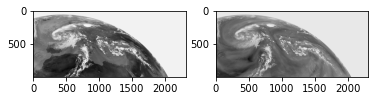

In [53]:
# Рассчитаем разности каналов
btd_1 = img_dict['WV_062'] - img_dict['IR_108']
btd_2 = img_dict['WV_062'] - img_dict['WV_073']

# Визуализируем результат
fig, ax = plt.subplots(1, 2)
ax[0].imshow(btd_1, cmap='gray')
ax[1].imshow(btd_2, cmap='gray')

In [54]:
# Преобразуем изображения в формат uint8 с помощью нормализации


def normalize(img, min_val, max_val, bg_mask):
    """Функция для нормализации
    Args:
        img (np.ndarray): исходное изображение типа float
        min_val (float): минимальное значение для нормализации
        max_val (float): максимальное значение для нормализации
        bg_mask (np.ndarray): маска заднего плана 
            (за пределами Земного диска) той же формы, что и img
    Returns:
        np.ndarray: нормализованное изображение в формате uint8
""" 
    
    
    img_norm = np.zeros_like(img)
    
    # Учитываем только значения в пределах Земного диска
    values = img[~bg_mask].copy()

    # Уберём значения вне границ (приравняем к ближайшей границе)
    values = np.clip(values, min_val, max_val)

    # Нормализация 
    values = np.round((values - min_val) / (max_val - min_val) * 255)

    img_norm[~bg_mask] = values

    # Меняем тип для 255-битного изображения
    img_norm = img_norm.astype(np.uint8)

    return img_norm


[]

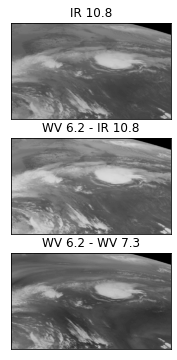

In [55]:
# Маска "заднего плана" - за пределами Земного диска
bg_mask = img_dict['IR_108'] == 0

# Границы нормализации для каждого канала
ir_norm = normalize(img_dict['IR_108'], 180, 340, bg_mask)
btd_1_norm = normalize(btd_1, -100, 20, bg_mask)
btd_2_norm = normalize(btd_2, -30, 10, bg_mask)

# Выполняем инверсию канала IR 10.8 (только в пределах Земного диска)
ir_norm[~bg_mask] = 255 - ir_norm[~bg_mask]

# Визуализируем результат - только область
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].imshow(ir_norm[100:400, 500:1000], cmap='gray', vmin=0, vmax=255)
ax[0].title.set_text('IR 10.8')
ax[0].set_xticks([]) 
ax[0].set_yticks([]) 

ax[1].imshow(btd_1_norm[100:400, 500:1000], cmap='gray', vmin=0, vmax=255)
ax[1].title.set_text('WV 6.2 - IR 10.8')
ax[1].set_xticks([]) 
ax[1].set_yticks([]) 

ax[2].imshow(btd_2_norm[100:400, 500:1000], cmap='gray', vmin=0, vmax=255)
ax[2].title.set_text('WV 6.2 - WV 7.3')
ax[2].set_xticks([]) 
ax[2].set_yticks([]) 

([], [])

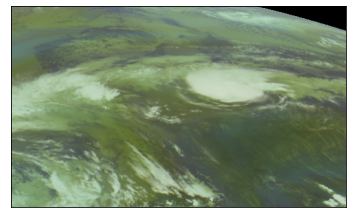

In [56]:
# Строим RGB-изображение
img_rgb = np.stack([ir_norm, btd_1_norm, btd_2_norm], axis=-1)

# Визуализируем результат
plt.imshow(img_rgb[100:400, 500:1000])
plt.xticks([]) 
plt.yticks([]) 

# Задание

Границы нормализации нужно подобрать таким образом, чтобы облачность глубокой конвекции на изображении имела цвет (оттенок), заметно отличающийся от цвета (оттенка) облачности другого типа. На данный момент, вся облачность закрашена белым цветом.
